# StateFarm Code Screen 

> Now running MLs

## 1. Import basic libraries

In [1]:
# Basic Libraries 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc


pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None
#pd.set_option("display.precision", 10)

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
# Basic PySpark Libraries

# Old Style : SparkContext 
#from pyspark import SparkContext   
#from pyspark.sql import SQLContext


# New Style : Spark Session  
#Shell-Mode: Spark Session Name is `spark`

sc = spark.sparkContext
sqlsc = SQLContext(sc)
sc.setCheckpointDir("hdfs://master:54310/tmp/spark/checkpoints")

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

In [3]:
# Enable Arrow for boosting up python performances 
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## 2. Read and check `mldata` 

In [4]:
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
mldata = sqlsc.read.parquet("hdfs://master:54310/data/spark/statefarm/mldata.parquet.snappy")

In [6]:
mldata.cache()

DataFrame[x0: double, x1: double, x2: double, x3: double, x4: double, x5: double, x6: double, x7: double, x8: double, x9: double, x10: double, x11: double, x12: double, x13: double, x14: double, x15: double, x16: double, x17: double, x18: double, x19: double, x20: double, x21: double, x22: double, x23: double, x24: double, x25: double, x26: double, x27: double, x28: double, x29: double, x30: double, x31: double, x32: double, x33: double, x36: double, x37: double, x38: double, x39: double, x40: double, x42: double, x43: double, x44: double, x46: double, x47: double, x48: double, x49: double, x50: double, x51: double, x52: double, x53: double, x54: double, x55: double, x56: double, x57: double, x58: double, x59: double, x60: double, x61: double, x62: double, x63: double, x64: double, x65: double, x66: double, x67: double, x69: double, x70: double, x71: double, x72: double, x73: double, x74: double, x75: double, x76: double, x77: double, x78: double, x79: double, x80: double, x81: double,

In [7]:
mldata.count()

40000

## 3. Run MLs 

### 3.1 Trying `LightGBM` from mmlspark

> Website : https://github.com/Azure/mmlspark/blob/master/docs/lightgbm.md

In [8]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

In [9]:
from mmlspark import LightGBMClassifier

In [10]:
gbclassifier = LightGBMClassifier(learningRate=0.3, numIterations=100,\
                                  #earlyStoppingRound=10,\
                                  labelCol='y',featuresCol='features')

In [11]:
paramGrid = ParamGridBuilder().addGrid(gbclassifier.numLeaves, [10, 30, 60]).build()
gbeval = BCE(labelCol='y',metricName='areaUnderROC')

In [12]:
gbcrossval = CrossValidator(estimator=gbclassifier, estimatorParamMaps=paramGrid,\
                            evaluator=gbeval,numFolds=4)

#### Fit 

In [13]:
%%time
gbcvmodel  = gbcrossval.fit(mldata)

CPU times: user 3.58 s, sys: 1.19 s, total: 4.77 s
Wall time: 58min 57s


In [14]:
print "AUCs = ",gbcvmodel.avgMetrics

AUCs =  [0.9782492012027678, 0.9855458223012217, 0.9869506235525165]


> Okey, the `LightGBM` worked too good. This could be an **overfit**, or the **magic** of LightGBM.

In [15]:
gbcvmodel.write().overwrite().save("hdfs://master:54310/data/spark/statefarm/gbcvmodel.mlmodel")

### 3.2 Trying `RandomForestClassifier` from SparkML

In [16]:
from pyspark.ml.classification import RandomForestClassifier

In [17]:
rfclassifier = RandomForestClassifier(labelCol='y',featuresCol='features')

In [18]:
rfparamGrid = ParamGridBuilder()\
                .addGrid(rfclassifier.maxDepth, [10, 30])\
                .addGrid(rfclassifier.maxBins, [20, 60])\
                .addGrid(rfclassifier.numTrees, [20, 40, 60])\
                .build()

In [19]:
rfeval = BCE(labelCol='y',metricName='areaUnderROC')

In [20]:
rfcrossval = CrossValidator(estimator=rfclassifier, estimatorParamMaps=rfparamGrid,\
                            evaluator=rfeval,numFolds=4)

#### Fit

In [21]:
%%time
rfcvmodel  = rfcrossval.fit(mldata)

CPU times: user 2.47 s, sys: 637 ms, total: 3.11 s
Wall time: 18min 18s


In [22]:
rfcvmodel.avgMetrics

[0.9452913506888451,
 0.9440974523469841,
 0.95912165677448,
 0.9586397951645473,
 0.9649417647790887,
 0.9655997963702295,
 0.9389402510177853,
 0.9389799662233435,
 0.9613648622919817,
 0.9618717604944418,
 0.9692202040722852,
 0.9694437431114269]

In [23]:
rfcvmodel.write().overwrite().save("hdfs://master:54310/data/spark/statefarm/rfcvmodel.mlmodel")

### 3.3 Feature Importance

In [24]:
# Covert the Vector-assembled feature importances to human-readables 
def ExtractFeatureImportance(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

#### Random Forest

In [25]:
rfFeatureImportance = ExtractFeatureImportance(rfcvmodel.bestModel.featureImportances,mldata,'features')

In [26]:
rfFeatureImportance.head(10)

,idx,name,score
107,70,x75,0.038254
72,35,x37,0.029113
128,91,x97,0.027363
91,54,x58,0.026898
131,94,x41n,0.022157
38,1,x1,0.019956
130,93,x99,0.018365
99,62,x66,0.016562
83,46,x50,0.015782
84,47,x51,0.015781


#### Displaying Top 40 Important Features

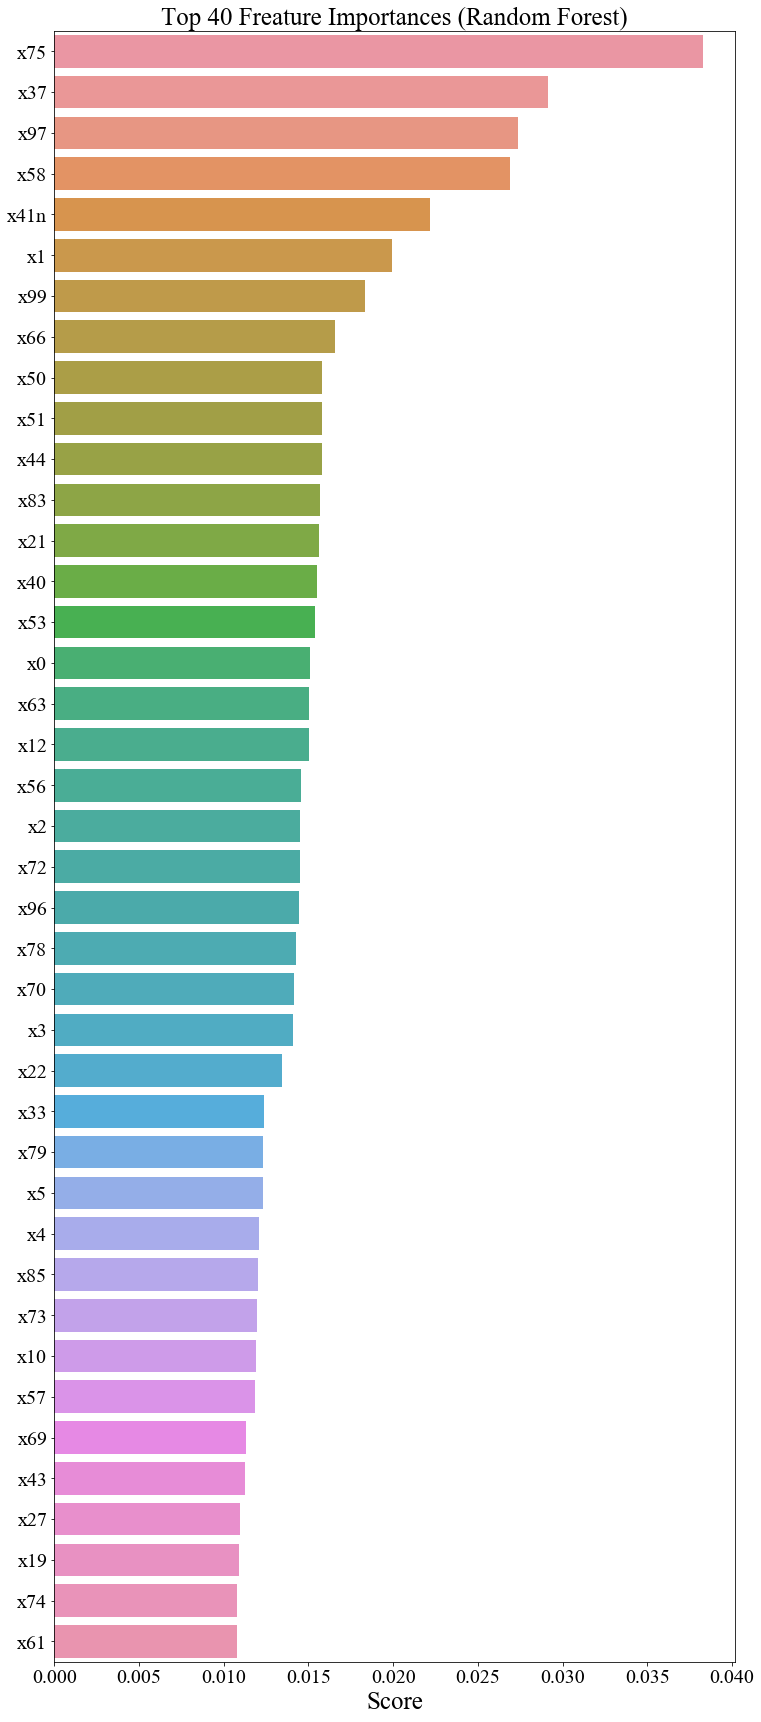

In [27]:
import seaborn as sbn
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12.2,30))

bar = sbn.barplot(x='score',y='name',data=rfFeatureImportance[:40])
bar.axes.set_title("Top 40 Freature Importances (Random Forest)",fontsize=25)
bar.set_xlabel("Score",fontsize=25)
bar.set_ylabel("",fontsize=25)
bar.tick_params(labelsize=20)

#plt.tight_layout()
plt.savefig('rfFeatures.png')
plt.savefig('rfFeatures.pdf')

plt.show()

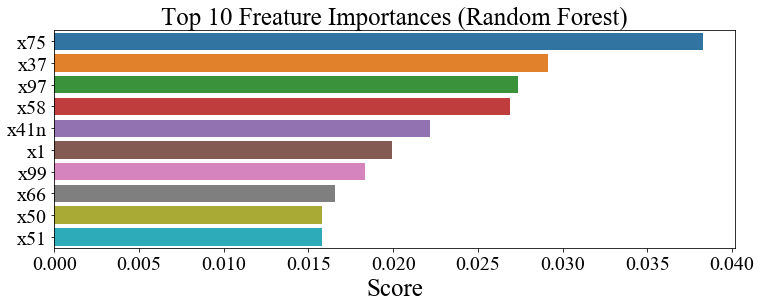

In [28]:
import seaborn as sbn
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12.2,4))

bar = sbn.barplot(x='score',y='name',data=rfFeatureImportance[:10])
bar.axes.set_title("Top 10 Freature Importances (Random Forest)",fontsize=25)
bar.set_xlabel("Score",fontsize=25)
bar.set_ylabel("",fontsize=25)
bar.tick_params(labelsize=20)

#plt.tight_layout()
plt.savefig('rfFeaturesTop10.png')
plt.savefig('rfFeaturesTop10.pdf')

plt.show()

#### Confusion Matrix

#### `RandomForestClassifier`

In [29]:
predictrf = rfcvmodel.bestModel.transform(mldata.select('features'))

In [30]:
mldata.select('features','y')\
      .join(predictrf.select('features','probability','prediction'),mldata.features==predictrf.features)\
      .show(5)

+--------------------+---+--------------------+--------------------+----------+
|            features|  y|            features|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[64.0295669054785...|  0|[64.0295669054785...|         [0.95,0.05]|       0.0|
|[69.2776483129675...|  0|[69.2776483129675...|[0.96666666666666...|       0.0|
|[-44.850336171895...|  0|[-44.850336171895...|[0.96666666666666...|       0.0|
|[34.3506047407032...|  0|[34.3506047407032...|[0.93333333333333...|       0.0|
|[-19.594669949303...|  0|[-19.594669949303...|         [0.95,0.05]|       0.0|
+--------------------+---+--------------------+--------------------+----------+
only showing top 5 rows



In [31]:
resultrf = \
mldata.select('features','y')\
      .join(predictrf.select('features','probability','prediction'),mldata.features==predictrf.features)

In [32]:
resultrf.cache()

DataFrame[features: vector, y: bigint, features: vector, probability: vector, prediction: double]

In [33]:
resultrf.crosstab('y','prediction').show()

+------------+-----+----+
|y_prediction|  0.0| 1.0|
+------------+-----+----+
|           1|    2|8045|
|           0|31953|   0|
+------------+-----+----+



In [34]:
from pyspark.sql.functions import udf
secondelement=udf(lambda v:float(v[1]),T.FloatType())

In [35]:
resultrf.select(secondelement('probability').alias('probone'),'prediction').show(20)

+-----------+----------+
|    probone|prediction|
+-----------+----------+
|       0.05|       0.0|
|0.033333335|       0.0|
|0.033333335|       0.0|
| 0.06666667|       0.0|
|       0.05|       0.0|
| 0.11666667|       0.0|
|0.083333336|       0.0|
|0.016666668|       0.0|
|       0.05|       0.0|
| 0.11666667|       0.0|
|       0.05|       0.0|
|       0.05|       0.0|
|0.033333335|       0.0|
|        0.0|       0.0|
|0.016666668|       0.0|
|0.016666668|       0.0|
|       0.05|       0.0|
|  0.9166667|       1.0|
|  0.8333333|       1.0|
|       0.05|       0.0|
+-----------+----------+
only showing top 20 rows



#### `LightGBM`

In [36]:
predictgb = gbcvmodel.bestModel.transform(mldata.select('features'))

In [37]:
predictgb.columns

['features', 'rawPrediction', 'probability', 'prediction']

In [38]:
predictgb.show(5)

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[64.0295669054785...|[7.90519488541478...|[0.99963131341573...|       0.0|
|[69.2776483129675...|[5.36918573025178...|[0.99536367307985...|       0.0|
|[-44.850336171895...|[7.74717270236689...|[0.99956822440953...|       0.0|
|[34.3506047407032...|[4.89556787895991...|[0.99257586949965...|       0.0|
|[-19.594669949303...|[9.2752946790026,...|[0.99990629775275...|       0.0|
+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [39]:
mldata.select('features','y')\
      .join(predictgb.select('features','probability','prediction'),mldata.features==predictgb.features)\
      .show(5)

+--------------------+---+--------------------+--------------------+----------+
|            features|  y|            features|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[64.0295669054785...|  0|[64.0295669054785...|[0.99963131341573...|       0.0|
|[69.2776483129675...|  0|[69.2776483129675...|[0.99536367307985...|       0.0|
|[-44.850336171895...|  0|[-44.850336171895...|[0.99956822440953...|       0.0|
|[34.3506047407032...|  0|[34.3506047407032...|[0.99257586949965...|       0.0|
|[-19.594669949303...|  0|[-19.594669949303...|[0.99990629775275...|       0.0|
+--------------------+---+--------------------+--------------------+----------+
only showing top 5 rows



In [40]:
resultgb = \
mldata.select('features','y')\
      .join(predictgb.select('features','probability','prediction'),mldata.features==predictgb.features)

In [41]:
resultgb.cache()

DataFrame[features: vector, y: bigint, features: vector, probability: vector, prediction: double]

In [42]:
resultgb.crosstab('y','prediction').show()

+------------+-----+----+
|y_prediction|  0.0| 1.0|
+------------+-----+----+
|           1|    0|8047|
|           0|31953|   0|
+------------+-----+----+



In [43]:
resultgb.select(secondelement('probability').alias('probone'),'prediction').show(20)

+------------+----------+
|     probone|prediction|
+------------+----------+
| 3.686866E-4|       0.0|
| 0.004636327|       0.0|
|4.3177558E-4|       0.0|
|0.0074241306|       0.0|
| 9.370225E-5|       0.0|
|0.0067525283|       0.0|
|0.0012849318|       0.0|
| 9.104295E-5|       0.0|
|9.1411686E-4|       0.0|
| 0.003946923|       0.0|
|1.6671444E-4|       0.0|
|  0.00838991|       0.0|
|2.2858372E-5|       0.0|
|1.8013384E-4|       0.0|
|1.3242124E-4|       0.0|
|2.1763677E-5|       0.0|
|1.2909881E-5|       0.0|
|   0.9996309|       1.0|
|   0.9998456|       1.0|
| 4.271079E-4|       0.0|
+------------+----------+
only showing top 20 rows



#### Plot the confusion matrices though they are trivial

In [44]:
gbmresult = pd.DataFrame([[31953,0],[0,8047]],columns=['0','1'])
rfresult = pd.DataFrame([[31953,0],[2,8045]],columns=['0','1'])

In [45]:
gbmNorm = gbmresult.apply(lambda row: row/np.sum(row), axis=1)
rfNorm = rfresult.apply(lambda row: row/np.sum(row), axis=1)

In [46]:
gbmNorm

,0,1
0,1.0,0.0
1,0.0,1.0


In [47]:
rfNorm

,0,1
0,1.000000,0.000000
1,0.000249,0.999751


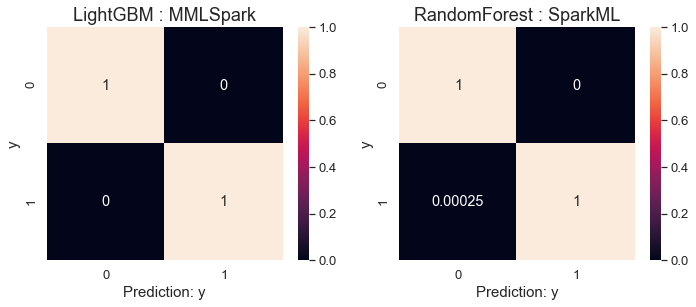

In [48]:
fig = plt.figure(figsize=(10,4.5))


sbn.set(font_scale=1.2)

plt.subplot(121)
hm = sbn.heatmap(gbmNorm, annot=True)
hm.axes.set_title("LightGBM : MMLSpark",fontsize=18)
hm.set_xlabel('Prediction: y',fontsize=15)
hm.set_ylabel('y',fontsize=15)



plt.subplot(122)
hm = sbn.heatmap(rfNorm, annot=True)
hm.axes.set_title("RandomForest : SparkML",fontsize=18)
hm.set_xlabel('Prediction: y',fontsize=15)
hm.set_ylabel('y',fontsize=15)



#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.tight_layout()
plt.savefig('result_ms.png')
plt.savefig('result_ms.pdf')

plt.show()

## 4. Predictions

### 4.1 Read the test sample

In [49]:
mldata_test = sqlsc.read.parquet("hdfs://master:54310/data/spark/statefarm/mldata_test.parquet.snappy")

In [50]:
mldata_test.count()

10000

In [51]:
predictgb_test = gbcvmodel.bestModel.transform(mldata_test.select('features'))

In [52]:
predictrf_test = rfcvmodel.bestModel.transform(mldata_test.select('features'))

In [53]:
resultgb_test = \
mldata_test.select('features')\
      .join(predictgb_test.select('features','probability','prediction'),mldata_test.features==predictgb_test.features)

In [54]:
resultrf_test = \
mldata_test.select('features')\
      .join(predictrf_test.select('features','probability','prediction'),mldata_test.features==predictrf_test.features)

In [55]:
resultgb_test.select('probability','prediction').show(10)

+--------------------+----------+
|         probability|prediction|
+--------------------+----------+
|[0.99949030801479...|       0.0|
|[0.05929797447763...|       1.0|
|[0.99972710327280...|       0.0|
|[0.97479532089856...|       0.0|
|[0.01199403922536...|       1.0|
|[0.99882018192223...|       0.0|
|[0.99980204844463...|       0.0|
|[0.99886143019124...|       0.0|
|[0.99959297921105...|       0.0|
|[0.94199653407149...|       0.0|
+--------------------+----------+
only showing top 10 rows



In [56]:
resultrf_test.select('probability','prediction').show(10)

+--------------------+----------+
|         probability|prediction|
+--------------------+----------+
|         [0.85,0.15]|       0.0|
|[0.66666666666666...|       0.0|
|[0.93333333333333...|       0.0|
|[0.73333333333333...|       0.0|
|[0.48333333333333...|       1.0|
|[0.86666666666666...|       0.0|
|           [0.9,0.1]|       0.0|
|[0.83333333333333...|       0.0|
|[0.88333333333333...|       0.0|
|[0.86666666666666...|       0.0|
+--------------------+----------+
only showing top 10 rows



In [57]:
resultgb_test.select(secondelement('probability').alias('probone')).show(10)

+------------+
|     probone|
+------------+
|  5.09692E-4|
|    0.940702|
|2.7289672E-4|
| 0.025204679|
|  0.98800594|
|0.0011798181|
|1.9795155E-4|
|0.0011385698|
| 4.070208E-4|
| 0.058003467|
+------------+
only showing top 10 rows



In [58]:
resultrf_test.select(secondelement('probability').alias('probone')).show(10)

+----------+
|   probone|
+----------+
|      0.15|
|0.33333334|
|0.06666667|
|0.26666668|
|0.51666665|
|0.13333334|
|       0.1|
|0.16666667|
|0.11666667|
|0.13333334|
+----------+
only showing top 10 rows



#### writing the predictions to `csv`

In [59]:
resultgb_test.select(secondelement('probability').alias('probone'))\
             .toPandas().to_csv('result1.csv',index=False,header=False)

In [60]:
resultrf_test.select(secondelement('probability').alias('probone'))\
             .toPandas().to_csv('result2.csv',index=False,header=False)